In [125]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import savemat
from scipy.signal import butter, filtfilt
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, optimal_leaf_ordering, fcluster
from scipy.stats import zscore
from sklearn.metrics import silhouette_score
from matplotlib.colors import ListedColormap
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter
from sklearn.metrics import (
    calinski_harabasz_score,
    davies_bouldin_score,
)
from scipy.signal import argrelmax, argrelmin
from scipy.ndimage import gaussian_filter1d
from pathlib import Path
from itertools import groupby


mpl.rcParams["font.family"] = "Arial"
mpl.rcParams["font.size"] = 8
mpl.rcParams["font.style"] = "normal"
mpl.rcParams["font.weight"] = "normal"
mpl.rcParams["font.stretch"] = "normal"

In [126]:
# ========================== HELPER FUNCTIONS ==============================
def butter_by_tau(wc):
    # 1st-order Butterworth low-pass; wc in (0,1) normalized
    wc = max(min(wc, 0.999), 1e-3)
    b, a = butter(1, wc, btype="low")
    return b, a


def load_sampling_rate(ksDir: Path):

    paramsPy = ksDir.joinpath("params.py")
    if not paramsPy.exists():
        raise RuntimeError(
            "params.py not found; cannot determine sampling rate. "
            "Set fsOverride manually."
        )

    txt = paramsPy.read_text()
    m = re.search(r"sample_rate\s*=\s*([\d\.]+)", txt)
    if m:
        return float(m.group(1))
    else:
        raise RuntimeError(
            "Could not parse sample_rate from params.py. " "Set fsOverride manually."
        )


def set_axis_scientific_powerlimits(axe, xaxis=False, yaxis=False):
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((0, 0))
    if xaxis:
        axe.xaxis.set_major_formatter(formatter)
    if yaxis:
        axe.yaxis.set_major_formatter(formatter)

In [ ]:
# ============================= USER SETTINGS =============================
# Sorting results in Phy directory:
dt_folder = Path(r"J:\project_trainingAggression\Data")
Agg = ["975826", "975833", "978772", "978775", "988590", "1010820", "1010823", "1010826"]
nonAgg = ["975827", "975830", "978774", "1010819", "997839", "997840","997841"]
maladaptive = []

phyPathList = sorted(
    f for f in dt_folder.rglob("*sorter_output")
    if "obs3" in str(f) and any(s in str(f) for s in maladaptive)
)

fsOverride = 0  # if ~None, overrides sampling rate from params.py
dtFR = 0.05  # firing-rate resolution with seconds per bin
taus = [0.2, 1.0, 2.5, 5.0]  # smoothing constants
tauIndex = 2

distMetric = "correlation"
linkMethod = "complete"

behavSeq = ["InitialBaseline","Milk","Break","Urine","Break",
            "Anticipation","Fight","RedLight","Urine","Break",
            "Milk","FinalBaseline"]  # Behavior label
epochDurSec = [45, 75, 30, 105, 30, 60, 60*5, 60*5, 105, 30, 75, 45]; 


# ================= HISTOLOGY-BASED AREA MAP FOR NP1.0 CHANNELS ============
brainArea = {
    "brain": np.arange(1, 384 + 1),
}  # brainArea.<name>.brainAelectrode
areaNames = list(brainArea.keys())

nAreas = len(areaNames)
areaNamesFull = [
    "brain",
]  # Full descriptive names for possible use

miceNames = np.arange(len(phyPathList))
nMice = len(miceNames)
print(areaNames)

['brain']


In [128]:
# ============================== MAIN LOGIC ================================
frList = []
frZList = []
goodcluBestchList = []
goodcluBestChAreaStrList = []
goodcluBestChAreaCodeList = []
goodcluToMiceList = []

totalnUnits = 0
totalnUnitsGood = 0

for phyPath, miceId in zip(phyPathList, miceNames):
    clusterInfoPath = phyPath / "autoForNeuroConcat/cluster_info.tsv"

    print(phyPath.parent.parent.name)

    # Loads from KS / Phy
    spikeAmplitudes = np.load(phyPath / "amplitudes.npy")
    spikeSec = np.load(phyPath / next(phyPath.rglob("spike_seconds_imec*")).name).astype(float)
    spikeClusters = np.load(phyPath / "spike_clusters.npy").astype(int)

    # Sample rate and units
    fs = load_sampling_rate(phyPath)
    print(f"Using sampling rate fs = {fs:.3f} Hz")

    spikeClusterIds = np.unique(spikeClusters)
    nUnits = spikeClusterIds.shape[0]
    totalnUnits += nUnits

    TminSec = 0.0
    TmaxSec = float(spikeSec.max())

    # ---------------- Load cluster info ----------------
    if not clusterInfoPath.exists():
        raise FileNotFoundError(f"cluster_info.tsv not found in {phyPath}")

    cluInfo = pd.read_csv(clusterInfoPath, sep="\t")
    if "cluster_id" not in cluInfo.columns:
        raise RuntimeError("cluster_info.tsv must contain 'cluster_id' column.")
    if "ch" not in cluInfo.columns:
        raise RuntimeError("cluster_info.tsv must contain 'ch' column.")


    cluGrp = cluInfo["group"].astype("string").str.strip().str.lower().fillna("unsorted").to_numpy()


    # rows in cluInfo that are good -> cluster IDs
    goodRows = np.where(cluGrp == "good")[0]
    goodClusterIds = cluInfo.loc[goodRows, "cluster_id"].to_numpy(int)

    # keep only cluster IDs that actually appear in spikeClusters
    goodClusterIds = goodClusterIds[np.isin(goodClusterIds, spikeClusterIds)]
    nGood = goodClusterIds.shape[0]

    totalnUnitsGood += nGood
    print(
        f"Detected [{nUnits} ({totalnUnits})] [{nGood} ({totalnUnitsGood})] units; recording duration {TmaxSec:.1f} s"
    )

    if nGood == 0:
        continue

    # ---------------- (Optional) MAP EACH UNIT TO A BRAIN AREA ----------------
    # If you are not using anatomy, you can delete this entire block safely.
    cluBestCh = cluInfo["ch"].to_numpy(dtype=int)
    cluId_all = cluInfo["cluster_id"].to_numpy(dtype=int)
    ch_by_id = dict(zip(cluId_all, cluBestCh))

    goodcluBestchTemp = np.array([ch_by_id[cid] for cid in goodClusterIds], dtype=int)

    # If you don't have real brainArea mapping, this will just assign "brain" using your dummy map.
    goodcluBestChAreaStrTemp = np.empty(nGood, dtype=object)
    goodcluBestChAreaCodeTemp = np.zeros(nGood, dtype=int)

    for i, cid in enumerate(goodClusterIds):
        cBC = ch_by_id[cid] + 1
        assigned = False
        for aid, name in enumerate(areaNames):
            if cBC in brainArea[name]:
                goodcluBestChAreaStrTemp[i] = name
                goodcluBestChAreaCodeTemp[i] = aid
                assigned = True
                break
        if not assigned:
            goodcluBestChAreaStrTemp[i] = "unknown"
            goodcluBestChAreaCodeTemp[i] = -1

    goodcluBestchList.append(goodcluBestchTemp)
    goodcluBestChAreaStrList.append(goodcluBestChAreaStrTemp)
    goodcluBestChAreaCodeList.append(goodcluBestChAreaCodeTemp)
    goodcluToMiceList.append(np.zeros(nGood) + miceId)

    # ---------------- FIRING RATES ----------------
    # FIX: deterministic edges (prevents 24100 vs 24101 bin mismatch)
    nBins = int(np.floor((TmaxSec - TminSec) / dtFR))
    edges = TminSec + np.arange(nBins + 1) * dtFR

    frTemp = np.array([
        np.histogram(spikeSec[spikeClusters == cid], edges)[0] / dtFR
        for cid in goodClusterIds
    ])

    # ---------------- Smooth + Z-score (robust: no NaNs) ----------------
    frFL = np.zeros((nGood, nBins, len(taus)))
    for k, tau in enumerate(taus):
        b, a = butter_by_tau(dtFR / tau)
        for i in range(nGood):
            frFL[i, :, k] = filtfilt(b, a, frTemp[i, :])

    x = frFL[:, :, tauIndex]
    mu = x.mean(axis=1, keepdims=True)
    sd = x.std(axis=1, keepdims=True)

    frZTemp = np.zeros_like(x)
    ok = (sd[:, 0] > 0)
    frZTemp[ok] = (x[ok] - mu[ok]) / sd[ok]   # rows with sd=0 stay zeros (finite)

    frList.append(frTemp)
    frZList.append(frZTemp)

# ---------------- CONCATENATE ACROSS SESSIONS ----------------
if len(frList) == 0:
    raise RuntimeError("No GOOD units found in any session.")

# Optional safety net: crop to common bin length (should be unnecessary now, but safe)
minBins = min(a.shape[1] for a in frList)
frList  = [a[:, :minBins] for a in frList]
frZList = [a[:, :minBins] for a in frZList]

fr = np.concatenate(frList, axis=0)
frZ = np.concatenate(frZList, axis=0)

print(fr.shape, frZ.shape)

# If you kept the anatomy lists:
goodcluBestch = np.concatenate(goodcluBestchList, axis=0) if len(goodcluBestchList) else np.array([])
goodcluBestChAreaStr = np.concatenate(goodcluBestChAreaStrList, axis=0) if len(goodcluBestChAreaStrList) else np.array([])
goodcluBestChAreaCode = np.concatenate(goodcluBestChAreaCodeList, axis=0) if len(goodcluBestChAreaCodeList) else np.array([])
goodcluToMice = np.concatenate(goodcluToMiceList, axis=0) if len(goodcluToMiceList) else np.array([])


20250818_m975827_obs3_g0_imec0
Using sampling rate fs = 30000.872 Hz
Detected [269 (269)] [43 (43)] units; recording duration 1205.0 s
20250818_m975827_obs3_g0_imec1
Using sampling rate fs = 30000.656 Hz
Detected [374 (643)] [97 (140)] units; recording duration 1205.0 s
20250818_m975827_obs3_g0_imec2
Using sampling rate fs = 30000.661 Hz
Detected [295 (938)] [38 (178)] units; recording duration 1205.0 s
20250818_m975830_obs3_g0_imec0
Using sampling rate fs = 30000.872 Hz
Detected [376 (1314)] [88 (266)] units; recording duration 1205.0 s
20250818_m975830_obs3_g0_imec1
Using sampling rate fs = 30000.656 Hz
Detected [724 (2038)] [259 (525)] units; recording duration 1205.0 s
20250818_m975830_obs3_g0_imec2
Using sampling rate fs = 30000.661 Hz
Detected [201 (2239)] [56 (581)] units; recording duration 1205.0 s
20250929_m978774_obs3_g0_imec0
Using sampling rate fs = 30000.872 Hz
Detected [376 (2615)] [66 (647)] units; recording duration 1205.0 s
20250929_m978774_obs3_g0_imec1
Using samplin

In [129]:
winA = np.arange(int(nBins / 9), int(2 * nBins / 9))
winF = np.arange(int(4 * nBins / 9), int(5 * nBins / 9))
winP = np.arange(int(7 * nBins / 9), int(8 * nBins / 9))
winAll = np.concatenate([winA, winF, winP])
frHC = np.concatenate(
    (
        fr[:, winA],
        fr[:, winF],
        fr[:, winP],
    ),
    axis=1,
)
ZFR = linkage(frHC, metric=distMetric, method=linkMethod, optimal_ordering=True)
frZHC = np.concatenate(
    (
        fr[:, winA],
        fr[:, winF],
        fr[:, winP],
    ),
    axis=1,
)
ZFRZ = linkage(frZHC, metric=distMetric, method=linkMethod, optimal_ordering=True)

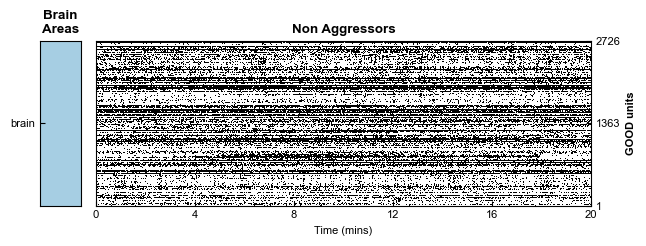

In [ ]:
frBinary = fr.copy()
frBinary[frBinary != 0] = 1

areaNamesFull = ["brain"]

# reorder by area
reOrder = np.argsort(goodcluBestChAreaCode)
areaCodesOrdered = goodcluBestChAreaCode[reOrder]
brainMat = areaCodesOrdered[:, None]

# ---- ONE brain strip + ONE FR plot (no separation) ----
fig, (axBrain, axFR) = plt.subplots(
    1, 2,
    figsize=(6.5, 2.5),
    gridspec_kw={"width_ratios": [0.5, 6]},
)

# brain strip
areaColorList = plt.get_cmap("Paired").colors[:nAreas]
cmapArea = ListedColormap(areaColorList)
axBrain.imshow(
    brainMat,
    cmap=cmapArea,
    origin="lower",
    aspect="auto",
    interpolation="none",
    vmin=-0.5,
    vmax=nAreas - 0.5,
)
axBrain.set_xticks([])

uniqueAreas = np.unique(areaCodesOrdered)
yticks, ylabels = [], []
for a in uniqueAreas:
    idx = np.where(areaCodesOrdered == a)[0]
    yticks.append(idx.mean())
    ylabels.append(areaNamesFull[int(a)])

axBrain.set_yticks(yticks)
axBrain.set_yticklabels(ylabels, rotation=0)
axBrain.tick_params(direction="in")
axBrain.set_title("Brain\nAreas", fontweight="bold")

# single raster (all data)
axFR.imshow(
    frBinary[reOrder, :],
    cmap="gray_r",
    origin="lower",
    aspect="auto",
    interpolation="none",
    vmin=0,
    vmax=1,
)

# y-axis
nGood = frBinary.shape[0]
axFR.set_yticks([0, int((nGood - 1) / 2), (nGood - 1)])
axFR.set_yticklabels([1, int((nGood - 1) / 2) + 1, nGood])
axFR.set_ylabel("GOOD units", fontweight="bold")
axFR.tick_params(direction="in")
axFR.yaxis.set_label_position("right")
axFR.yaxis.tick_right()

# x-axis in minutes across the full recording
total_minutes = (frBinary.shape[1] * dtFR) / 60.0
xt = np.linspace(0, frBinary.shape[1] - 1, 6)
xl = np.linspace(0, total_minutes, 6)
axFR.set_xticks(xt)
axFR.set_xticklabels([f"{v:.0f}" for v in xl])
axFR.set_xlabel("Time (mins)")

# only title requested
axFR.set_title("Maladaptive", fontweight="bold")

plt.tight_layout()
plt.show()


## Graph clustering

In [131]:
from scipy import stats as ss
from scipy.linalg import issymmetric
import igraph as ig


similarityMethod = "Spearmanr"
sigThreshold = 99.


r = np.zeros((nGood, nGood), dtype=np.float32)
p = np.zeros((nGood, nGood), dtype=np.float32)
if similarityMethod == "Spearmanr":
    r, p = ss.spearmanr(frZ, axis=1)
if similarityMethod == "Pearsonr":
    # for i in range(nGood):
    #     for j in range(i + 1, nGood):
    #         r[i, j], p[i, j] = ss.pearsonr(frZ[i, :], frZ[j, :])
    #         r[j, i], p[j, i] = r[i, j], p[i, j]
    r = np.corrcoef(frZ)
    df = nGood - 2
    r_clip = np.clip(r, -0.9999999, 0.9999999)
    t = r_clip * np.sqrt(df / (1.0 - r_clip**2))
    p = 2 * ss.t.sf(np.abs(t), df)
if similarityMethod == "Euclidean":
    for i in range(nGood):
        for j in range(i + 1, nGood):
            d = np.linalg.norm(frZ[i, :] - frZ[j, :])
            r[i, j] = d
            r[j, i] = d

In [132]:
hcRanking = []
rThreshold = 99
while rThreshold >= 50:
    s = np.around(r, 8)
    s[s <= 0] = -1
    notSig = p >= (1 - sigThreshold / 100)
    s[notSig] = -1
    p[notSig] = -1
    np.fill_diagonal(s, -1)
    if rThreshold != 0:
        rf = s.flatten().astype(np.float32)
        rf = rf[rf != -1]
        hr = np.percentile(rf, rThreshold)
        del rf
        s = np.where(s < hr, 0, s)
    else:
        s = np.where(s == -1, 0, s)
    # print(
    #     f"Is symmetric: {issymmetric(s)}",
    #     f"\tDensity: {np.count_nonzero(s) / (nGood * (nGood - 1))}",
    # )

    g = ig.Graph.Weighted_Adjacency(
        s.tolist(),
        mode="UNDIRECTED",
        attr="weight",
    )
    dendro = g.community_fastgreedy(weights="weight")
    # dendro = g.community_fastgreedy()
    clusters = dendro.as_clustering()
    comps = g.components()
    # print(
    #     f"Modularity: {clusters.modularity}",
    #     f"\tClusters: {len(clusters)}",
    #     f"\tComponents: {len(comps)}",
    # )

    hcRanking.append([rThreshold, clusters.modularity, len(clusters), len(comps), comps.giant().vcount() / nGood])
    rThreshold -= 0.05
hcRanking = np.array(hcRanking)

77.55000000000122 0.15325594
Modularity: 0.46083014602188976 	Clusters: 5 	Components: 1
[] [5450]


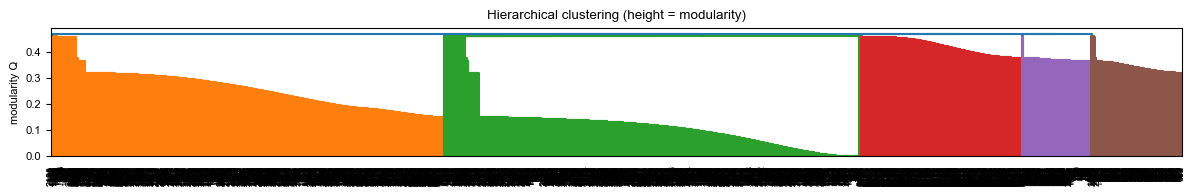

In [133]:
# ---- 1. igraph: network ----
allIdx = np.where(hcRanking[:, 3] == 1)[0]
finalRThreshold = hcRanking[:, 0][allIdx[np.argmax(hcRanking[allIdx, 1])]]
s = np.around(r, 8)
s[s <= 0] = -1
notSig = p >= (1 - sigThreshold / 100)
s[notSig] = -1
p[notSig] = -1
np.fill_diagonal(s, -1)
if finalRThreshold != 0:
    rf = s.flatten().astype(np.float32)
    rf = rf[rf != -1]
    hr = np.percentile(rf, finalRThreshold)
    del rf
    s = np.where(s < hr, 0, s)
else:
    s = np.where(s == -1, 0, s)
print(finalRThreshold, np.min(s[s != 0]))
# plt.hist(s[s != 0].flatten(), bins=100)

# ---- 2. igraph: fastgreedy ----
g = ig.Graph.Weighted_Adjacency(
    s.tolist(),
    mode="UNDIRECTED",
    attr="weight",
)
comps = g.components()
dendro = g.community_fastgreedy(weights="weight")
# dendro = g.community_fastgreedy()
clustersBest = dendro.as_clustering()
cluMembership = clustersBest.membership
kBest = len(clustersBest)
print(
    f"Modularity: {clustersBest.modularity}",
    f"\tClusters: {len(clustersBest)}",
    f"\tComponents: {len(comps)}",
)

# ---- 3. dendrogram → SciPy linkage ----
valideMerges = np.array(dendro.merges)
validMergesLength = valideMerges.shape[0]
merges = np.zeros((nGood - 1, 3))
fullRange = np.arange(nGood, int(2 * nGood - 1))
merges[:, 2] = fullRange
merges[:validMergesLength, :2] = valideMerges
counts = np.zeros(nGood - 1, dtype=float)
heightsMod = np.zeros(nGood - 1, dtype=float)

cluserUsed = np.sort(np.unique(valideMerges[valideMerges >= nGood]))
missing = np.sort(np.setdiff1d(fullRange, cluserUsed))
loops = [comp[0] for comp in comps if len(comp) == 1]
iLoops = 0
iMissing = 0
print(loops, missing)
for i in range(nGood - 1):
    if i < validMergesLength:
        c1, c2 = valideMerges[i, 0], valideMerges[i, 1]
        k = nGood - (i + 1)
        vc = dendro.as_clustering(n=k)
        q = vc.modularity
    else:
        c1 = missing[iMissing]
        c2 = missing[iMissing + 1]
        if c1 < merges[i, 2]:
            iMissing += 1
        if c2 < merges[i, 2]:
            iMissing += 1
        else:
            c2 = loops[iLoops]
            iLoops += 1
        merges[i, 0], merges[i, 1] = c1, c2
        q = 0
    heightsMod[i] = q if q >= 0 else 0
    count1 = 1 if c1 < nGood else counts[c1 - nGood]
    count2 = 1 if c2 < nGood else counts[c2 - nGood]
    counts[i] = count1 + count2
heightsAccu = np.maximum.accumulate(heightsMod)
idxMaxAccu = np.argmax(heightsAccu)
heightsAccu[idxMaxAccu + 1:] += 1e-2
# SciPy linkage: (idx1, idx2, height, count)
manualLinkage = np.column_stack([merges[:, :2], heightsAccu, counts])

# ---- 4. dendrogram ----
i_cut = nGood - kBest - 1
if i_cut < len(heightsAccu) - 1:
    cut_height = 0.5 * (heightsAccu[i_cut] + heightsAccu[i_cut + 1])
else:
    cut_height = heightsAccu[i_cut] + 1e-6
plt.figure(figsize=(12, 2))
dendrogram(
    manualLinkage,
    labels=list(range(nGood)),
    orientation="top",
    color_threshold=cut_height,
    leaf_font_size=6.5,
    distance_sort=True,
)
plt.ylabel("modularity Q")
plt.title("Hierarchical clustering (height = modularity)")
plt.tight_layout()
plt.show()

In [134]:
Z = manualLinkage
elbowIdx = np.argmax(Z[:, 2]) - 1
kBest = nGood - (elbowIdx + 1)
leafOrder = np.array(
    dendrogram(Z, distance_sort=True, no_plot=True)["leaves"], dtype=int
)
cluInLeafOrder = fcluster(Z, kBest, criterion="maxclust")[leafOrder]

In [135]:
def intra_cluster_sorting(leafOrder, cluInLeafOrder, sortingMethod):
    if sortingMethod == "byGreedyCorr":
        newLeafOrder = leafOrder.copy()
        for c in np.unique(cluInLeafOrder):
            pos = np.where(cluInLeafOrder == c)[0]
            idx = leafOrder[pos]
            m = len(idx)
            if m <= 2:
                continue

            frSub = frZ[idx, :][:, winAll]
            R = np.corrcoef(frSub)
            R = np.nan_to_num(R, nan=0.0)
            np.fill_diagonal(R, -1)
            i0, j0 = divmod(np.argmax(R), m)
            orderLocal = [i0, j0]
            used = np.zeros(m, bool)
            used[i0] = True
            used[j0] = True
            cur = j0

            for _ in range(m - 2):
                corrRow = R[cur].copy()
                corrRow[used] = -1
                nxt = np.argmax(corrRow)
                orderLocal.append(nxt)
                used[nxt] = True
                cur = nxt
            newLeafOrder[pos] = idx[orderLocal[::-1]]
            return newLeafOrder
    return None


leafOrderNew = intra_cluster_sorting(
    leafOrder, cluInLeafOrder, sortingMethod="byGreedyCorr"
)

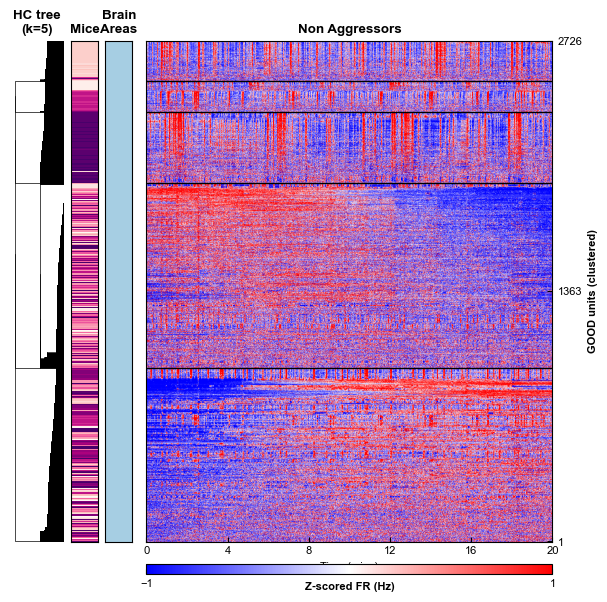

In [ ]:
# ---------- Plot dendrogram + mice + brainArea + ONE heatmap ----------
# Assumes you already have: Z, elbowIdx, kBest, leafOrderNew, cluInLeafOrder,
# frZ, goodcluToMice, goodcluBestChAreaCode, nMice, nAreas, miceNames, areaNames

from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

fig, (axD, axMice, axBrain, axH) = plt.subplots(
    1,
    4,
    figsize=(7, 6.5),
    gridspec_kw={"width_ratios": [1.0, 0.5, 0.5, 7.5]},
)

# ==================== keep your manual positioning logic (adapted) ====================
posD = axD.get_position()
posH = axH.get_position()
left = posD.x0
right = posH.x1
y0 = posD.y0
height = posD.height

wD_rel = 1.0
wM_rel = 0.5
wB_rel = 0.5
wH_rel = 7.5

gap_L = 0.01     # D~M, M~Brain
gap_mid = 0.02   # Brain~Heatmap

total_rel = wD_rel + wM_rel + wB_rel + wH_rel
total_gap = 2 * gap_L + gap_mid
total_width = right - left
unit = (total_width - total_gap) / total_rel

wD = wD_rel * unit
wM = wM_rel * unit
wB = wB_rel * unit
wH = wH_rel * unit

xD = left
xM = xD + wD + gap_L
xBrain = xM + wM + gap_L
xH = xBrain + wB + gap_mid

axD.set_position([xD, y0, wD, height])
axMice.set_position([xM, y0, wM, height])
axBrain.set_position([xBrain, y0, wB, height])
axH.set_position([xH, y0, wH, height])
# ======================================================================

# ---------------- dendrogram (same as yours) ----------------
thr = Z[elbowIdx, 2] + 1e-6
ddata = dendrogram(
    Z,
    color_threshold=thr,
    above_threshold_color="k",
    distance_sort=True,
    no_plot=True,
    no_labels=True,
)
icoord = ddata["icoord"]
dcoord = ddata["dcoord"]
colors = ddata["color_list"]
maxd = max(max(y) for y in dcoord)
ratio_low = 0.5

def squash(d):
    d = np.asarray(d, float)
    out = d.copy()
    low = d <= thr
    high = d > thr
    out[low] = ratio_low * d[low]
    scale_high = (maxd - ratio_low * thr) / (maxd - thr)
    out[high] = ratio_low * thr + (d[high] - thr) * scale_high
    return out

axD.cla()
maxd_new = squash([maxd])[0]
for xs, ys, c in zip(icoord, dcoord, colors):
    d_new = squash(ys)
    x = maxd_new - d_new
    y = xs
    axD.plot(x, y, color="k", linewidth=0.5)

margin = 0.1 * maxd_new
axD.set_xlim(-margin, maxd_new)
axD.set_ylim(min(min(x) for x in icoord), max(max(x) for x in icoord))
axD.set_title("HC tree" + "\n" + f"(k={kBest})", fontweight="bold")
axD.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
for spine in axD.spines.values():
    spine.set_visible(False)

# ---------------- mice strip ----------------
miceCodesOrdered = goodcluToMice[leafOrderNew]
miceMat = miceCodesOrdered[:, None]
miceColorList = plt.get_cmap("RdPu")(np.linspace(0, 1, nMice))
cmapMice = ListedColormap(miceColorList)

axMice.imshow(
    miceMat,
    cmap=cmapMice,
    origin="lower",
    aspect="auto",
    interpolation="none",
    vmin=-0.5,
    vmax=nMice - 0.5,
)
axMice.set_xticks([])
axMice.set_yticks([])
axMice.set_title("Mice", fontweight="bold")

# ---------------- brainarea strip ----------------
areaCodesOrdered = goodcluBestChAreaCode[leafOrderNew]
brainMat = areaCodesOrdered[:, None]
areaColorList = plt.get_cmap("Paired").colors[:nAreas]
cmapArea = ListedColormap(areaColorList)

axBrain.imshow(
    brainMat,
    cmap=cmapArea,
    origin="lower",
    aspect="auto",
    interpolation="none",
    vmin=-0.5,
    vmax=nAreas - 0.5,
)
axBrain.set_xticks([])
axBrain.set_yticks([])
axBrain.set_title("Brain\nAreas", fontweight="bold")

# ---------------- ONE heatmap (no splitting) ----------------
nBins = frZ.shape[1]
im = axH.imshow(
    frZ[leafOrderNew, :],
    cmap="bwr",
    origin="lower",
    aspect="auto",
    vmin=-1,
    vmax=1,
)

# x ticks: minutes across full recording (needs dtFR defined)
total_minutes = (nBins * dtFR) / 60.0
xt = np.linspace(0, nBins - 1, 6)
xl = np.linspace(0, total_minutes, 6)
axH.set_xticks(xt)
axH.set_xticklabels([f"{v:.0f}" for v in xl])

# y ticks
nGood = frZ.shape[0]
axH.set_yticks([0, int((nGood - 1) / 2), (nGood - 1)])
axH.set_yticklabels([1, int((nGood - 1) / 2) + 1, nGood])
axH.tick_params(direction="in")
axH.yaxis.set_label_position("right")
axH.yaxis.tick_right()
axH.set_ylabel("GOOD units (clustered)", fontweight="bold")
axH.set_xlabel("Time (mins)")
axH.set_title("Maladaptive", fontweight="bold")

# cluster separation lines (same logic)
for b in np.where(np.diff(cluInLeafOrder) != 0)[0] + 0.5:
    axH.axhline(b, color="k", linewidth=1)

# ---------------- colorbar under heatmap ----------------
bbox_h = axH.get_position()
cbar_height = 0.015
cbar_pad = 0.035
cax = fig.add_axes([bbox_h.x0, bbox_h.y0 - cbar_pad - cbar_height, bbox_h.width, cbar_height])

cbar = fig.colorbar(im, cax=cax, orientation="horizontal")
cbar.set_label("Z-scored FR (Hz)", fontweight="bold")
cbar.ax.xaxis.labelpad = -5
cbar.set_ticks([-1, 1])
cbar.ax.tick_params(direction="in")

plt.show()


In [ ]:

Aggressors = frZ.T

In [137]:
nonAggressors = frZ.T